In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Implementing BERT on CommonLit Readability kaggle Dataset**

In this competition the goal is to predict the ease of reading excerpts https://www.kaggle.com/c/commonlitreadabilityprize/overview

3:50am  started training


### Installing additional Libraries
If you are working on Google Colab:

- We need to install transformers library by huggingface
- tensorflow-gpu to work using gpu

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 43.6 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 895 kB 38.5 MB/s 
     |████████████████████████████████| 6.5 MB 37.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 497.5 MB 27 kB/s 
     |████████████████████████████████| 462 kB 27.5 MB/s 


### Check the GPU

In [ ]:
!nvidia-smi

Wed Apr  6 03:26:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Importing Libraries
- pandas to read csv files and other data preprocessing
- Numpy for arrays and Linear algebra
- we use Tensorflow to build and train the model using bert
- transformers library by huggingface for pretrained bert model ( 'pip install transformers' - to install transformers library )

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model


In [ ]:

from transformers import TFBertModel, BertConfig, BertTokenizerFast

https://products.aspose.app/pdf/conversion/zip-to-csv  --> to extract csv from zip online and store in commonLit folder

### Hugging Face Dcoumentation

https://huggingface.co/docs/transformers/quicktour

In [ ]:

train_path = '/content/drive/MyDrive/commonLit/train.csv'
test_path = '/content/drive/MyDrive/commonLit/test.csv'

train_df = pd.read_csv(train_path)

test_df = pd.read_csv(test_path)

train_df.head()

FileNotFoundError: ignored

In [ ]:
ex_len = []
for i in train_df['excerpt']:
  ex_len.append(len(i.split()))
print('max length of text: ', max(ex_len), 'words')

max length of text:  205 words


**BERT has a max sequence length of 512 tokens.**

If the text sequence length is more than the limit then we have 4 options (consider based on their importance):

1. truncating at the end
2. take the end part
3. take the middle part
4. join the first and last part by removing the middle


according to this research, cutting middle part shows best accuracy: 
https://arxiv.org/abs/1905.05583



# Tokenisation

In [ ]:
train_df['excerpt'][0]

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

### BERT model
- `BERT Large` – 24-layer, 1024-hidden, 16-heads, 336M parameters
- `BERT base` – 12-layer, 768-hidden, 12-heads, 110M parameters
- `cased` – Trained on cased English text
- `uncased` – Trained on lower-cased English text

**link for more info:** 
https://huggingface.co/models

In [ ]:
bert_model = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(bert_model)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

[Docs](https://huggingface.co/transformers/glossary.html#input-ids) to learn about inputs to BERT model

In [ ]:
def encoder(df, tokenizer, label = 'excerpt', maxLen = 210):
    input_id = []
    token_type = []
    attention_mask = []
    for i in df[label].values:
        token = tokenizer(i, max_length = maxLen, truncation = True, padding = 'max_length', add_special_tokens = True)
        input_id.append(token['input_ids'])
        token_type.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    return np.array(input_id), np.array(token_type), np.array(attention_mask)

#### No need of pre - processing the text
  
* stemming: Bert uses BPE (Byte- Pair Encoding to shrink its vocab size), so words like run and running will ultimately be decoded to run + ##ing. So it's better not to convert running into run because, in some NLP problems, you need that information.
* De-Capitalization - Bert provides two models (lowercase and uppercase). One converts your sentence into lowercase, and others will not change related to the capitalization of your sentence. So you don't have to do any changes here just select the model for your use case.

In [ ]:
train_d = encoder(train_df, tokenizer)
test_d = encoder(test_df, tokenizer)

In [ ]:
train_d

(array([[  101,  2043,  1996, ...,  1010,  2021,   102],
        [  101,  2035,  2083, ...,  1010,  2017,   102],
        [  101,  2004,  5074, ...,  1010,  2205,   102],
        ...,
        [  101,  1996,  2117, ...,  4338,  2180,   102],
        [  101, 26778,  2024, ...,     0,     0,     0],
        [  101,  4176,  2024, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

In [ ]:
tok = train_d[0].flatten()[30:50]

print(train_d[0].shape, '\n')
print('original sequence:')
print(train_df['excerpt'][0].split()[30:50], '\n')
print('tokenised sequence:')
print(tokenizer.convert_ids_to_tokens(tok), '\n')
print(tokenizer.convert_ids_to_tokens(train_d[0].flatten()[0:10]))

(2834, 210) 

original sequence:
['canvas,', 'not', 'laid', 'on', 'smoothly,', 'but', 'rumpled', 'over', 'bumps', 'and', 'hillocks,', 'like', 'a', 'real', 'snow', 'field.', 'The', 'numerous', 'palms', 'and'] 

tokenised sequence:
['floor', 'was', 'covered', 'with', 'snow', '-', 'white', 'canvas', ',', 'not', 'laid', 'on', 'smoothly', ',', 'but', 'rum', '##pled', 'over', 'bumps', 'and'] 

['[CLS]', 'when', 'the', 'young', 'people', 'returned', 'to', 'the', 'ballroom', ',']


In [ ]:
# config will be downloaded and cached
model_config = BertConfig.from_pretrained(bert_model)

In [ ]:
model_config.output_hidden_states = True

In [ ]:
model_config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
# Downloads the model 
bert = TFBertModel.from_pretrained(bert_model, config = model_config)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# tunable parameters
max_len = 210
learning_rate = 1e-4
epochs = 3

# callbacks
ckpt_dir = '/content/drive/MyDrive/commonLit/checkpoint/ckpt{epoch:02d}.h5'
ckpt = ModelCheckpoint(
    filepath = ckpt_dir,
    save_freq = 'epoch',
    save_weights_only=True)

optimizer = Adam(learning_rate = learning_rate)
loss = 'mse'
metrics = [RootMeanSquaredError()]
callbacks = [ckpt]

#### Defining the model 
 * Takes 3 inputs i.e., input_ids, token_type_ids, attention_mask and are given to the bert layer
 * bert layer outputs a tuple of output of all the layers. we only consider the first sequence(output of [CLS] token), which is passed to hidden layers with linear activation
 * we use linear activation as the labels are integers 

In [ ]:
input_ids_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
token_type_ids_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'token_type_ids')
attention_mask_i = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')
inputs = [input_ids_i, token_type_ids_i, attention_mask_i]

bert_output = bert(input_ids_i, token_type_ids = token_type_ids_i, attention_mask = attention_mask_i)[0]
output = bert_output[:, 0, :]

output = Dropout(0.1)(output)

output = Dense(10, activation = 'linear')(output)
output = Dense(1, activation = 'linear')(output)

model = Model(inputs = inputs, outputs = output)

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 210)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 210)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 210)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

In [ ]:
print(bert_output.shape)

(None, 210, 768)


The output is usually [batch, maxlen, hidden_state], it can be narrowed down to [batch, 1, hidden_state] for [CLS] token, as the [CLS] token is 1st token in the sequence. Here , [batch, 1, hidden_state] can be equivalently considered as [batch, hidden_state].

Since BERT is transformer based contextual model, the idea is [CLS] token would have captured the entire context and would be sufficient for simple downstream tasks such as classification. Hence, for tasks such as classification using sentence representations, you can use [batch, hidden_state]. However, you can also consider [batch, maxlen, hidden_state], average across maxlen dimension to get averaged embeddings. However, some sequential tasks, such as classification using CNN or RNN requires, sequence of representations, during which you have to rely on [batch, maxlen, hidden_state]. Also, some training objectives such as predicting the masked words, or for SQUAD 1.1 (as shown in BERT paper), the entire sequence of embeddings [batch, maxlen, hidden_state] are used.

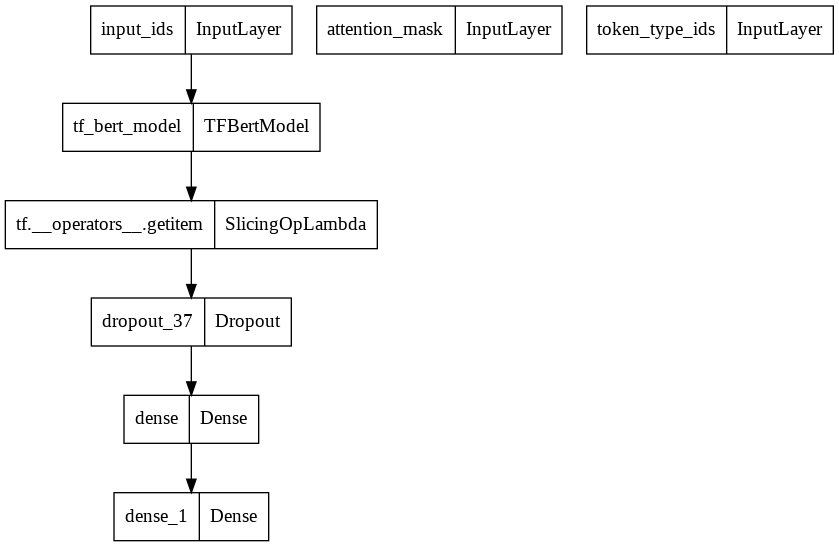

In [ ]:
plot_model(model)

In [ ]:
train_l = train_df['target'].values

val_prob = 0.1
split = int(len(train_l)*(1 - val_prob))
print(split)
print(2834 - split)
train_x = tuple(np.array(train_d)[:, :split, :])
train_y = train_l[:split]

val_x = tuple(np.array(train_d)[:, split:, :])
val_y = np.array(train_l[split:])
print(val_x[0].shape)
val_y.shape

2550
284
(284, 210)


(284,)

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Virtual devices cannot be modified after being initialized


In [ ]:
model.fit(train_x, train_y, validation_data = (val_x, val_y), epochs = epochs, callbacks = callbacks)
model.save_weights('/content/drive/MyDrive/commonLit/BERTv1.h5')

Epoch 1/3
80/80 [==============================] - 254s 3s/step - loss: 0.8797 - root_mean_squared_error: 0.9379 - val_loss: 0.7131 - val_root_mean_squared_error: 0.8445
Epoch 2/3
80/80 [==============================] - 231s 3s/step - loss: 0.2924 - root_mean_squared_error: 0.5407 - val_loss: 0.3981 - val_root_mean_squared_error: 0.6310
Epoch 3/3
80/80 [==============================] - 231s 3s/step - loss: 0.1638 - root_mean_squared_error: 0.4047 - val_loss: 0.4447 - val_root_mean_squared_error: 0.6669


In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = TFBertModel.load_model('/content/drive/MyDrive/commonLit/BERTv1.h5')

# Show the model architecture
new_model.summary()

In [ ]:
model.predict(test_d)

array([[-0.29415485],
       [-0.00346086],
       [-0.2391108 ],
       [-1.7013086 ],
       [-1.3775146 ],
       [-0.7117574 ],
       [ 0.7732226 ]], dtype=float32)

In [ ]:
text = ["TransUnion, LLC conducted an investigation into items listed on my credit report which I disputed in the month of XXXX XXXX. The investigation was completed according to paper work on XX/XX/2019 (see file# XXXX). In the investigation results it shows items listed below:  [XXXX XXXX - XXXX* - Verified as belonging to me] [XXXX/XXXX  XXXX  - *XXXX - Verified as belonging to me][XXXX/XXXX  XXXX - *XXXX  - Verified as belonging to me][XXXX/XXXX XXXX - XXXX* - Verified as belonging to me]  [XXXX  XXXX XXXX - XXXX* - Verified as belonging to me][XXXX  XXXX - XXXX* - Verified as belonging to me][XXXX  XXXX XXXX - #XXXX* - Verified as belonging to me (Same Item was removed from my XXXX  for lack of Verification)][XXXX  XXXX  XXXX  XXXX  - #unknown - Was never investigated, nor am I familiar with this collection as I've never gotten anything back from this collector proving this is my debt.]I have contacted each one of these companies for verifiable data which neither has been able to supply to me and I've asked TransUnion, LLC to complete a fair and thorough investigation into the matter and they have provided me with bogus results stating everything is verified. I then sent a Method of Verification letter on XX/XX/2019 which was CONFIRMED received onXX/XX/2019 to TransUnion, LLC exercising my rights under FCRA 611(a)(6)(B(iii) to provide me with proof they completed a thorough investigation properly and not via XXXX system and requested them to provide me with the description of the procedure used to determine the accuracy and completeness of the information. Name, Address, and telephone number of each person contacted regarding these alleged accounts. Finally, any documentation provided bearing my signature, showing I had a legally binding contractual obligation to pay them and exact amount claimed. As a result, I received a bogus response from TransUnion, LLC today stating a general explanation about their investigation process, but no proof of items in question ever being investigated. This was an improper Method of Verification response and against my FCRA right. I have attached all documentation backing up my claim for your review CFPB."


In [ ]:
testpath = '/content/drive/MyDrive/commonLit/test_c.csv'

test_cdf = pd.read_csv(testpath)

test_cdf.head()

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,"TransUnion, LLC conducted an investigation int..."
1,f0953f0a5,NaN,NaN,On XX/XX/2019 my bank card was charged XXXX fo...
2,0df072751,NaN,NaN,XXXX and Transunion are reporting incorrectly ...


In [ ]:
test_complaints_d = encoder(test_cdf, tokenizer)
model.predict(test_complaints_d)

array([[-2.4447432],
       [-1.2820559],
       [-1.704746 ]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


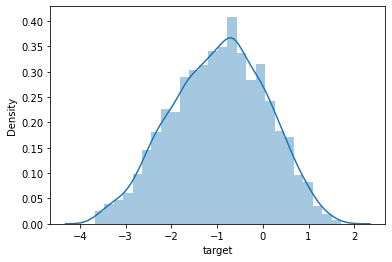

In [ ]:
import seaborn as sb
sb.distplot(train_df['target'])

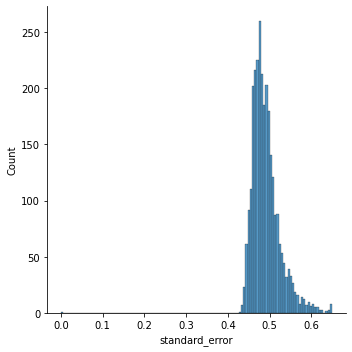

In [ ]:
sb.displot(train_df['standard_error']);

In [ ]:
cc_path = '/content/drive/MyDrive/commonLit/nan_removed_complaints.csv'

cc_df = pd.read_csv(cc_path)
cc_df.head(3)
#cc_d = encoder(cc_df, tokenizer)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Date_received,Product,Subproduct,Issue,Sub_issue,Unnamed: 5,gunning_fog_score,smog_index_score,num_difficult_words,flesch_reading_ease_score,...,State,ZIP_code,Tags,Consumer_consent_provided,Submitted via,Date_sent_to_company,Company_response_to_consumer,Timely_response,Consumer_disputed,Complaint_ID
0,18-08-2019,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,18.70,17.9,60,25.26,...,CA,90640.0,NaN,Consent provided,Web,18-08-2019,Closed with explanation,Yes,NaN,3345092
1,10-04-2019,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,22.10,19.1,76,24.55,...,GA,31321.0,NaN,Consent provided,Web,10-04-2019,Closed with explanation,Yes,NaN,3207366
2,09-03-2020,Mortgage,FHA mortgage,Struggling to pay mortgage,NaN,NaN,54.89,0.0,9,-40.18,...,PA,19151.0,NaN,Consent provided,Web,11-03-2020,Closed with explanation,Yes,NaN,3559311


In [ ]:
cc_df['Company_response_to_consumer'].unique() # 5 categories

array(['Closed with explanation', 'Closed with non-monetary relief',
       'Closed with monetary relief', 'Untimely response', 'Closed',
       'In progress', nan], dtype=object)

In [ ]:
df1 = cc_df.copy()

In [ ]:
pd.DataFrame(df1.Company_response_to_consumer.unique())

,0
0,Closed with explanation
1,Closed with non-monetary relief
2,Closed with monetary relief
3,Untimely response
4,Closed
5,In progress
6,NaN


In [ ]:
df1[df1.Company_response_to_consumer == "Closed with explanation"] = 1
df1[df1.Company_response_to_consumer == "Closed with non-monetary relief"] = 2
df1[df1.Company_response_to_consumer == "Closed with monetary relief"] = 3
df1[df1.Company_response_to_consumer == "Untimely response"] = 4
df1[df1.Company_response_to_consumer == "Closed"] = 5
df1[df1.Company_response_to_consumer == "In progress"] = 6
df1[df1.Company_response_to_consumer == "NaN"] = 7
df1

,Date_received,Product,Subproduct,Issue,Sub_issue,Unnamed: 5,gunning_fog_score,smog_index_score,num_difficult_words,flesch_reading_ease_score,...,State,ZIP_code,Tags,Consumer_consent_provided,Submitted via,Date_sent_to_company,Company_response_to_consumer,Timely_response,Consumer_disputed,Complaint_ID
0,1,1,1,1,1,1.0,1.0,1.0,1,1.0,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1.0,1.0,1.0,1,1.0,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1.0,1.0,1.0,1,1.0,...,1,1,1,1,1,1,1,1,1,1
3,2,2,2,2,2,2.0,2.0,2.0,2,2.0,...,2,2,2,2,2,2,2,2,2,2
4,1,1,1,1,1,1.0,1.0,1.0,1,1.0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500614,2,2,2,2,2,2.0,2.0,2.0,2,2.0,...,2,2,2,2,2,2,2,2,2,2
500615,1,1,1,1,1,1.0,1.0,1.0,1,1.0,...,1,1,1,1,1,1,1,1,1,1
500616,2,2,2,2,2,2.0,2.0,2.0,2,2.0,...,2,2,2,2,2,2,2,2,2,2
500617,1,1,1,1,1,1.0,1.0,1.0,1,1.0,...,1,1,1,1,1,1,1,1,1,1


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


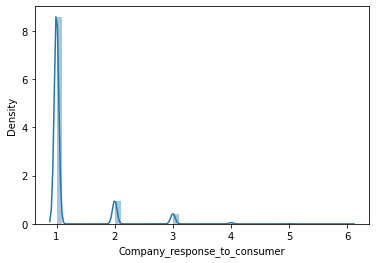

In [ ]:
sb.distplot(df1['Company_response_to_consumer'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


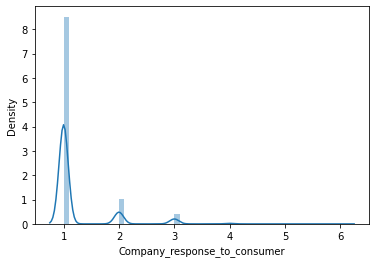

In [ ]:
df2 = df1.sample(10000, random_state=1).copy()
sb.distplot(df2['Company_response_to_consumer'])